In [24]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

## How many states can you disambiguate 

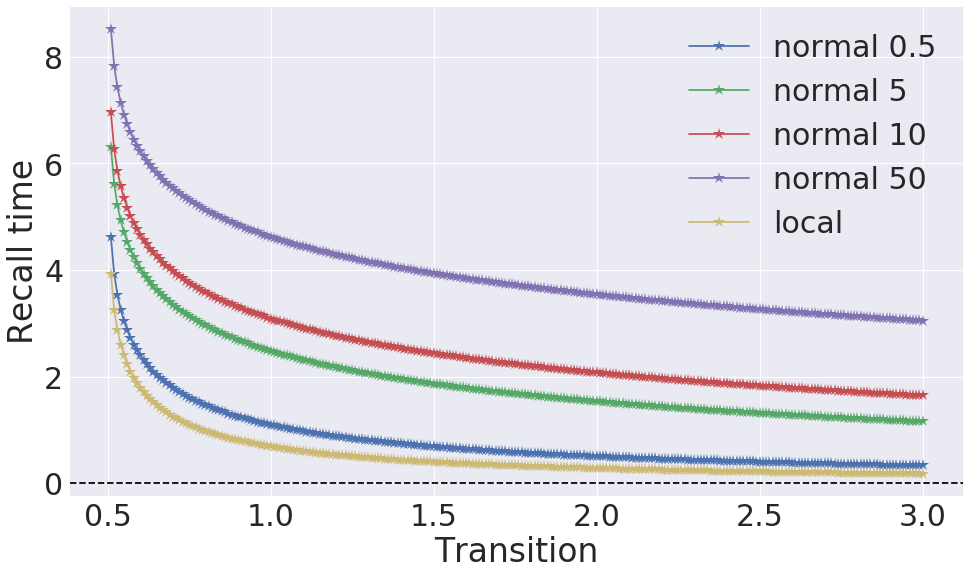

In [97]:
transition_vector = np.arange(0.51, 3.0, 0.01)
inhibitions = [0.5, 5, 10, 50]
threshold = 0.5
tau_z = 0.050

for inhibition in inhibitions:
    T1_theo = tau_z * np.log((transition_vector + inhibition) / (transition_vector - threshold))
    plt.plot(transition_vector, T1_theo, '*-', markersize=13, label='normal ' + str(inhibition))

T1_theo_local = tau_z * np.log(transition_vector/ (transition_vector - threshold))


plt.plot(transition_vector, T1_theo_local, '*-', markersize=13, label='local')
plt.axhline(0, ls='--', color='black')
plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

It seems that the disambiguation capacity of the system is really low. What if we did not have the lower limit for transition

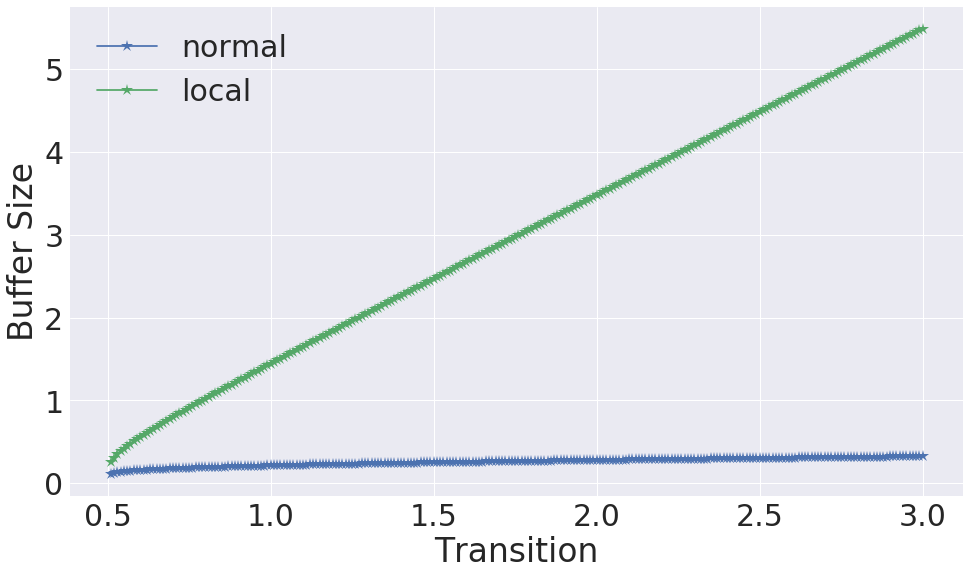

In [90]:
buffer_size = tau_z / T1_theo
buffer_size_local = tau_z / T1_theo_local

plt.plot(transition_vector, buffer_size, '*-', markersize=13, label='normal')
plt.plot(transition_vector, buffer_size_local, '*-', markersize=13, label='local')

plt.xlabel('Transition')
plt.ylabel('Buffer Size')
plt.legend();

This means that the local rule is better at disambiguation than the normal one. 

It is reasonable to use big inhibition so we will try a variation for tau_z with transition equal to 1.5 or in the middle of the plot above

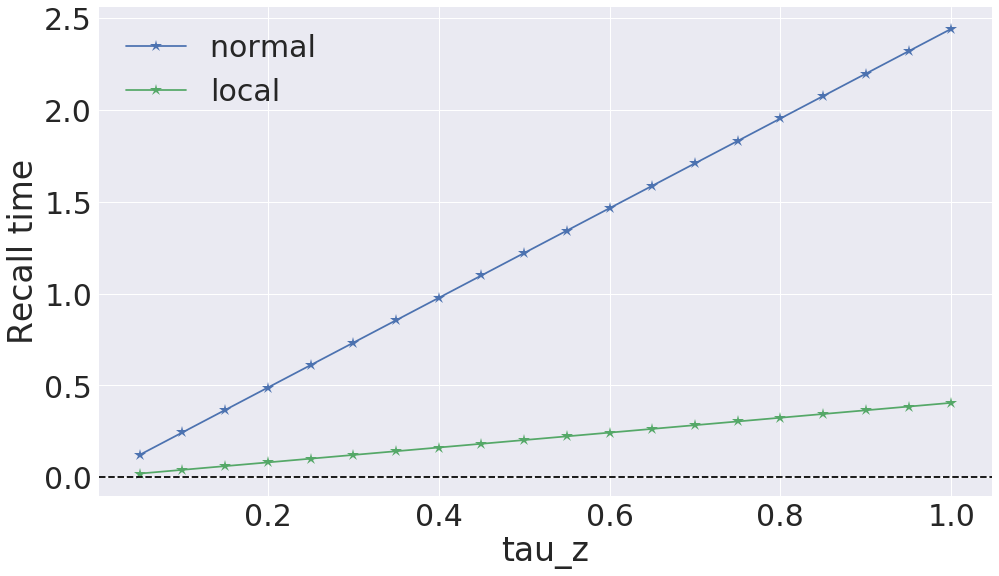

In [99]:
transition = 1.5
inhibition = 10.0
threshold = 0.5
tau_z_vector = np.arange(0.050, 1.050, 0.050)

T1_theo = tau_z_vector * np.log((transition + inhibition) / (transition - threshold))
T1_theo_local = tau_z_vector * np.log(transition/ (transition - threshold))


plt.plot(tau_z_vector, T1_theo, '*-', markersize=13, label='normal ')
plt.plot(tau_z_vector, T1_theo_local, '*-', markersize=13, label='local')
plt.axhline(0, ls='--', color='black')
plt.xlabel('tau_z')
plt.ylabel('Recall time')
plt.legend();

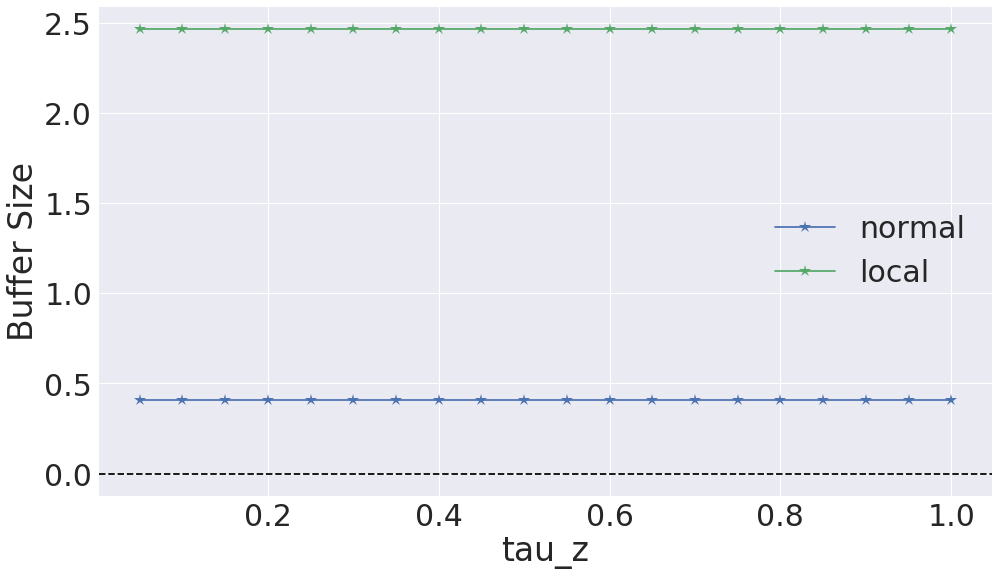

In [103]:
buffer_size = tau_z_vector / T1_theo
buffer_size_local = tau_z_vector / T1_theo_local

plt.plot(tau_z_vector, buffer_size, '*-', markersize=13, label='normal')
plt.plot(tau_z_vector, buffer_size_local, '*-', markersize=13, label='local')


plt.axhline(0, ls='--', color='black')
plt.xlabel('tau_z')
plt.ylabel('Buffer Size')
plt.legend();

## Working example of overlap

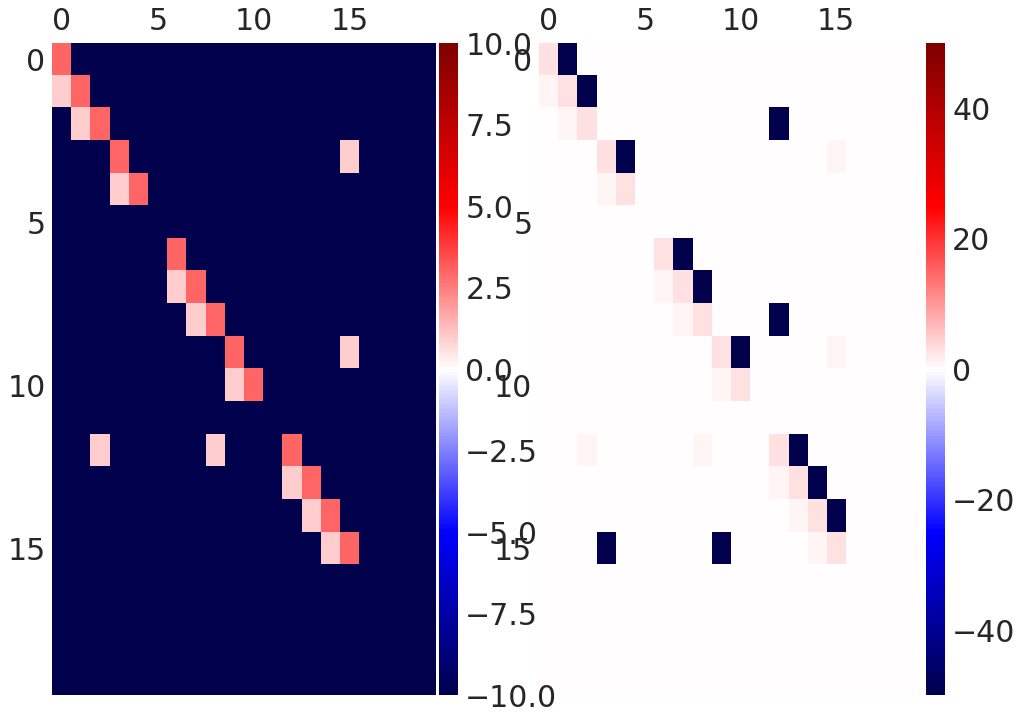

In [57]:
N = 20

dt = 0.0005
tau_m = 0.010
tau_z = 0.100
tau_a = 0.500

G = 100.0
self_excitation = 3.0
inhbition = 10.0
transition = 1.0
threshold = 0.5

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]
w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

symmetric = np.max((np.max(w1), np.abs(np.min(w1))))
im1 = ax1.matshow(w1, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax1.grid()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)


symmetric = np.max((np.max(w2), np.abs(np.min(w2))))
im2 = ax2.matshow(w2, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax2.grid()
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2);

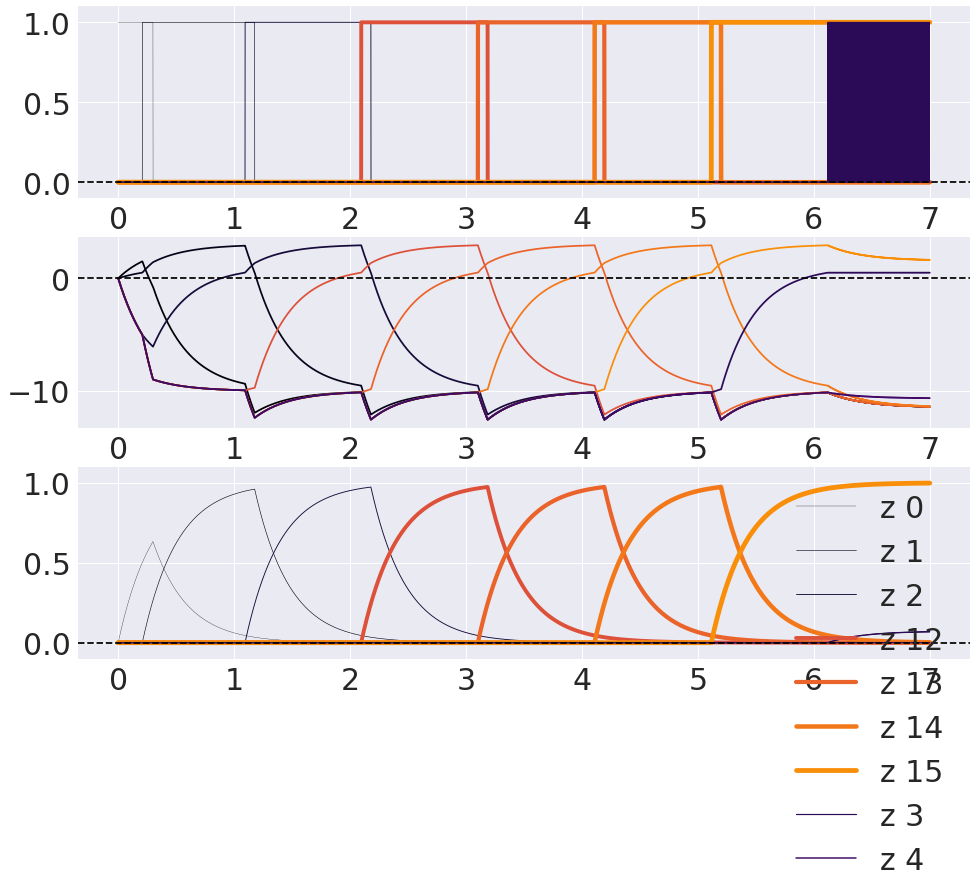

In [84]:
tau_z = 0.300
sigma = 0.0
w = w1

sequence_to_recall = sequences[0]
I_cue = sequence_to_recall[0]
T = 7.0
T_cue = tau_z

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

time = np.arange(0, T, dt)

norm = matplotlib.colors.Normalize(0, N)
cmap = matplotlib.cm.inferno

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = sequence_to_recall
for pattern in patterns:
    width = pattern * 0.3 + 0.3
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)),linewidth=width, label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], color=cmap(norm(pattern)), linewidth=width, label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
# ax1.legend();

ax1.set_ylim([-0.1, 1.1])
# ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
# ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

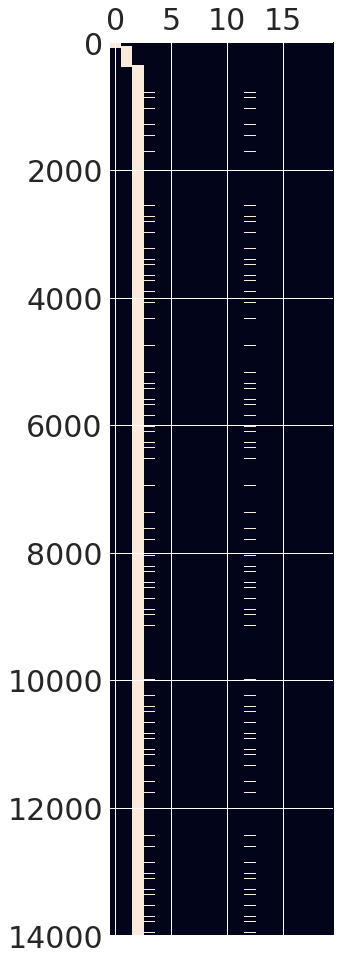

In [150]:
plt.matshow(x_history, aspect='auto')

What we see here is that the local system recalls both and the system with more inhibition stays undecisive at the bifurcation. This make sense. 

The effect mentioned above also happens for long tau_z.

Let's try to do some 

## Cosine Similiarty to patterns
Let's buld a function that will give us the distance to the patterns at the end

In [132]:
patterns_matrix = np.eye(N)

x = patterns_matrix[1]
y = x_history[0, :]

def cosine_similarity(x, y):
    
    cosine = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cosine

similarity_matrix = np.zeros_like(x_history)

for x_index, x in enumerate(x_history):
    for index, pattern in enumerate(patterns_matrix):
        similarity_matrix[x_index, index] = cosine_similarity(pattern, x)
        

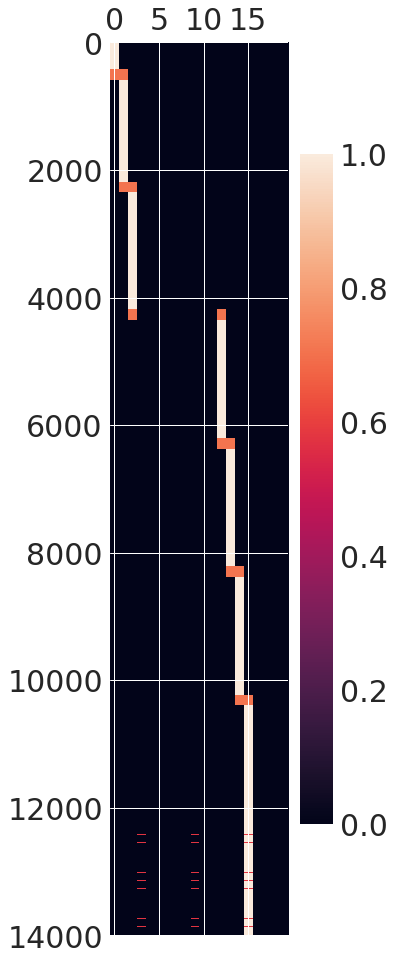

In [135]:
plt.matshow(similarity_matrix, aspect='auto')
plt.colorbar()

In [137]:
similarity_matrix[-1, :]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [142]:
x_history[-1, :]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.])

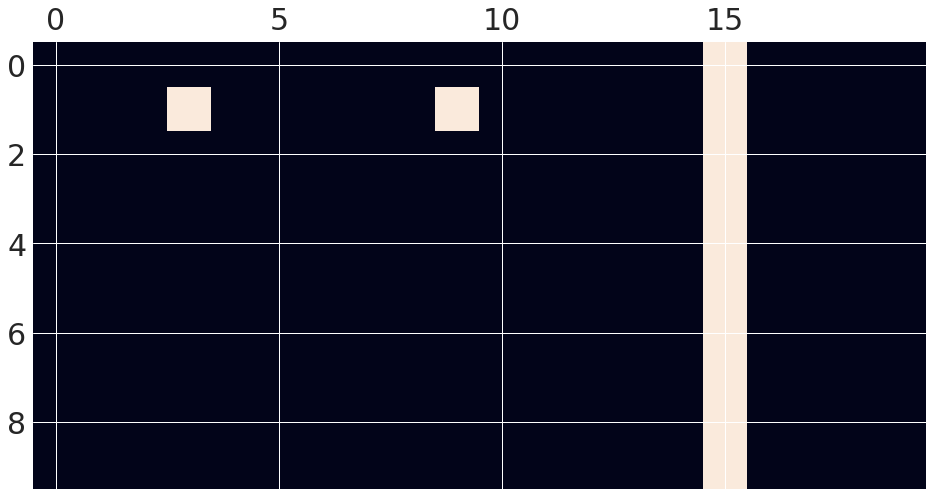

In [141]:
plt.matshow(x_history[-10:, :])

It seems that it will be enough to just take the final vector of x_history as an indicator of value

## Artificial added value

Same case as above but now we add the connections to bridge the overlap

In [174]:
N = 20

dt = 0.0005
tau_m = 0.010
tau_z = 0.100

G = 100.0
self_excitation = 5.0
inhbition = 20.0
transition = 3.0
threshold = 0.5

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]
w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)

2 to 9 -20.0
8 to 3 -20.0


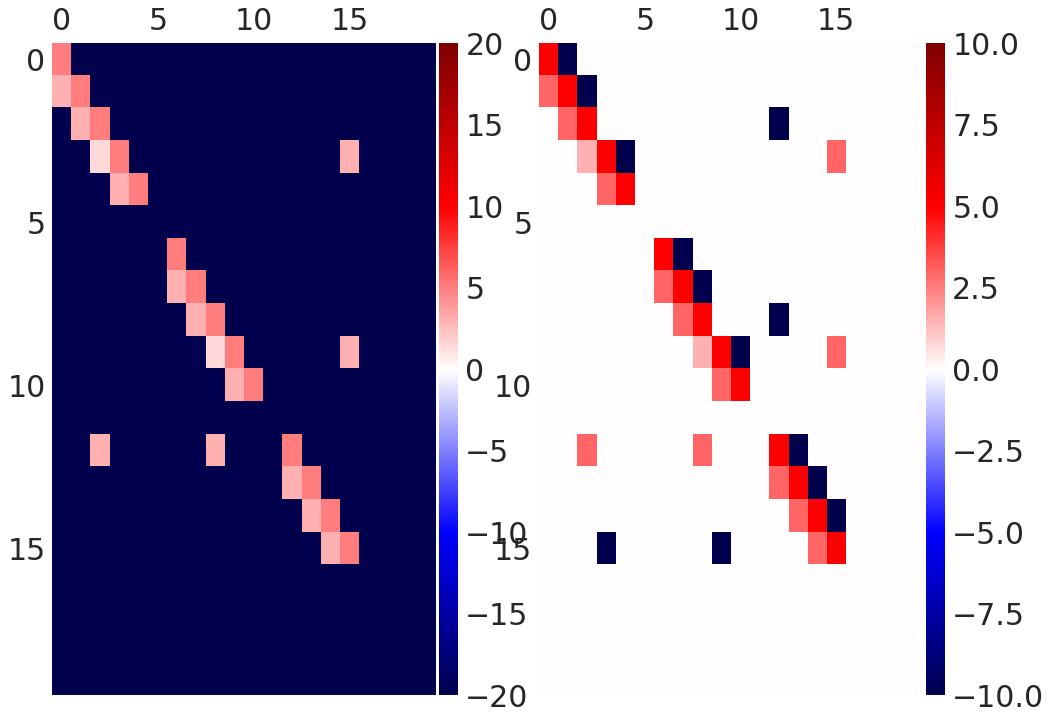

In [184]:
# Artificially added values
aux = transition * 0.5
w1[3, 2] = aux
w1[9, 8] = aux
w2[3, 2] = aux
w2[9, 8] = aux

print('2 to 9', w1[9, 2])
print('8 to 3', w1[3, 8])

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

symmetric = np.max((np.max(w1), np.abs(np.min(w1))))
im1 = ax1.matshow(w1, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax1.grid()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)


symmetric = np.max((np.max(w2), np.abs(np.min(w2))))
im2 = ax2.matshow(w2, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax2.grid()
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2);

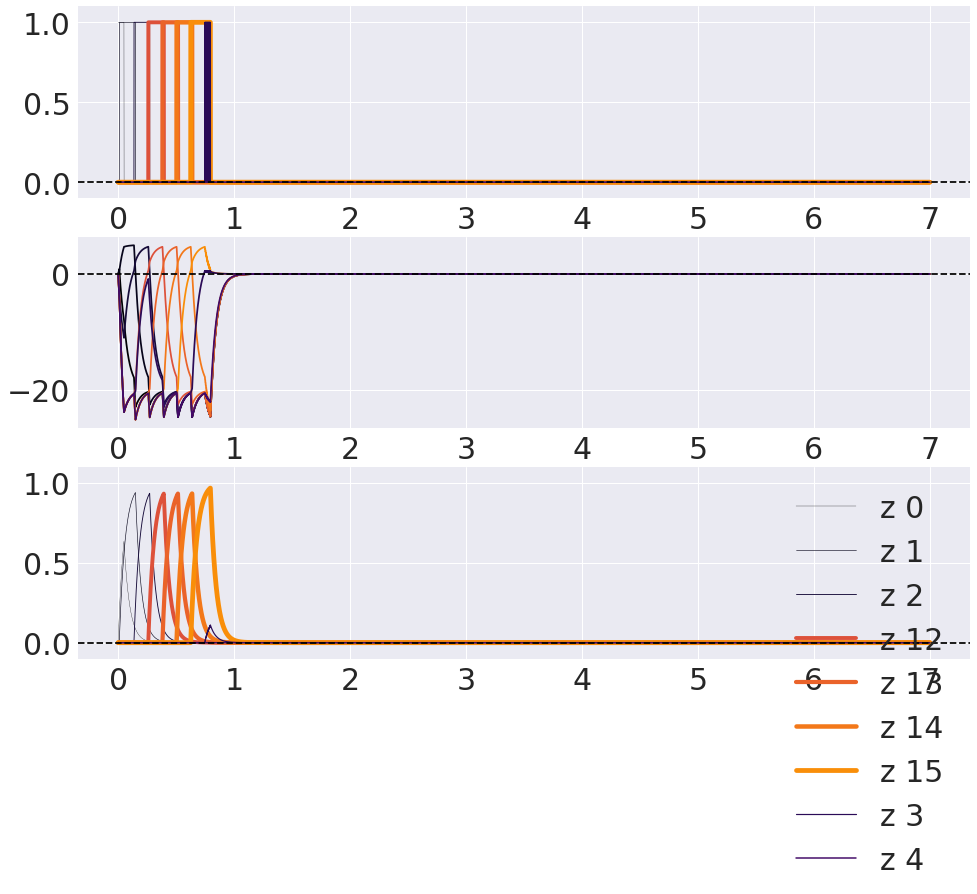

In [199]:
tau_z = 0.100
sigma = 0.0
w = w1

sequence_to_recall = sequences[0]
I_cue = sequence_to_recall[0]
T = 7.0
T_cue = tau_z

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

time = np.arange(0, T, dt)

norm = matplotlib.colors.Normalize(0, N)
cmap = matplotlib.cm.inferno

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = sequence_to_recall
for pattern in patterns:
    width = pattern * 0.3 + 0.3
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)),linewidth=width, label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], color=cmap(norm(pattern)), linewidth=width, label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
# ax1.legend();

ax1.set_ylim([-0.1, 1.1])
# ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
# ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

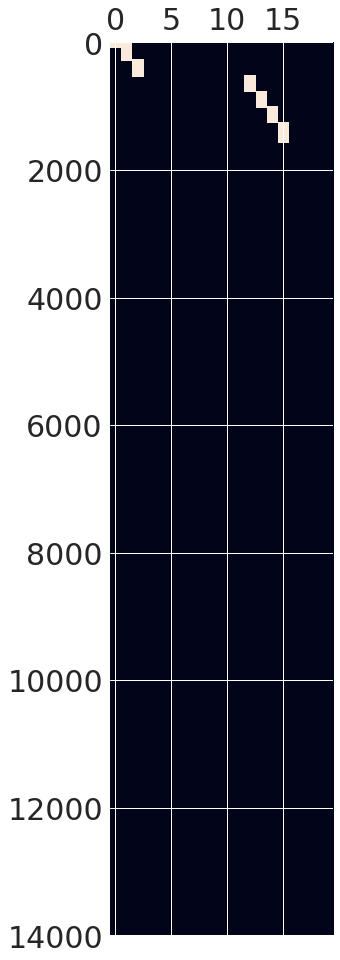

In [200]:
plt.matshow(x_history, aspect='auto')